This contains a skimage based solution to making the .as_signal() method run more quickly. It is currently broken, the solution will probably involve checking that both peaks land in the same place.

In [2]:
%matplotlib tk
import numpy as np
import hyperspy.api as hs
import pycrystem as pc
import pymatgen as pmg

In [3]:
si = pmg.Element("Si")
lattice = pmg.Lattice.cubic(5.431)
silicon = pmg.Structure.from_spacegroup("Fd-3m",lattice, [si], [[0, 0, 0]])

In [4]:
size = 256
radius= 1.5
max_r = 1.2
sigma = 0.03

ediff = pc.ElectronDiffractionCalculator(300., 0.025)
diff_dat = ediff.calculate_ed_data(silicon, radius)

In [5]:
%%time
dpi = diff_dat.as_signal(size, sigma, max_r)

CPU times: user 708 ms, sys: 24 ms, total: 732 ms
Wall time: 210 ms


In [6]:
ground_truth = pc.ElectronDiffraction(dpi)

In [7]:
ground_truth.plot()

In [8]:
diff_dat

In [9]:
l,delta_l = np.linspace(-max_r, max_r, size,retstep=True)
coords = diff_dat.coordinates[:, :2]

In [10]:
### old_version_of_as_signal    
"""
x, y = np.meshgrid(l, l)
dp_dat = 0
g = Expression(_GAUSSIAN2D_EXPR, 'Gaussian2D', module='numexpr')
for (cx, cy), intensity in zip(coords, self.intensities):
    g.intensity.value = intensity
    g.sigma.value = sigma
    g.cx.value = cx
    g.cy.value = cy
    dp_dat += g.function(x, y)
dp = ElectronDiffraction(dp_dat)
dp.set_calibration(2*max_r/size)
""";

In [53]:
import warnings
### current_single_peak_version
### This version involves a discretisation, which is bad.
#also could use numpy digitise and some of the stuf from peak_finders_2D
l,delta_l = np.linspace(-max_r, max_r, size,retstep=True)
signal = np.zeros([size,size])
for i in np.arange(coords.shape[0]):
    x,y = coords[i,0]-(delta_l/2),coords[i,1]-(delta_l/2)
    x_num,y_num = np.sum(l < x),np.sum(l < y)
    try:
        signal[x_num,y_num] += diff_dat.intensities[i]
    except IndexError:
        warnings.warn("Some co-ordinates (peaks) lie outside the desire value of max_r",RuntimeWarning)
        pass
from skimage.filters import gaussian as point_spread
signal = point_spread(signal,sigma=sigma/delta_l)
from pycrystem import ElectronDiffraction
dp = ElectronDiffraction(signal)
#dp.set_calibration(2*max_r/size)

/home/pc494/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Some co-ordinates (peaks) lie outside the desire value of max_r
  # This is added back by InteractiveShellApp.init_path()


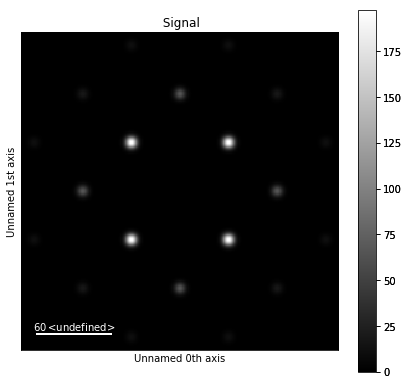

In [54]:
%matplotlib inline
ground_truth.plot()

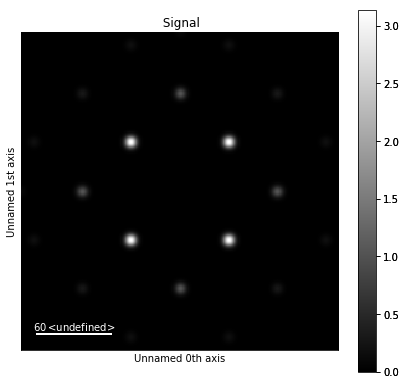

In [55]:
dp.plot()

In [56]:
ground_normalised = np.divide(ground_truth.data,np.max(ground_truth.data))
dp_normalised = np.divide(dp.data,np.max(dp.data))

In [57]:
np.sum(np.subtract(ground_normalised,dp_normalised))

3.3443537147896851

In [61]:
from matplotlib import pyplot as plt
%matplotlib tk
plt.imshow(np.subtract(ground_normalised,dp_normalised),cmap='viridis') #error on the diagonal

In [59]:
np.max(np.subtract(ground_normalised,dp_normalised))

0.10662906063259592

In [60]:
np.argmax((np.subtract(ground_normalised,dp_normalised)))

23130